In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt

import random
from collections import defaultdict

%matplotlib inline

In [2]:
DATA_DIR = "~/jupyter_notebooks/DATA/MarchMadness"

In [3]:
YEAR = 2018
raw_tournament_df = pd.read_csv(f"{DATA_DIR}/output/teams.csv")
tournament_df = raw_tournament_df[raw_tournament_df["Season"] == YEAR]
tournament_df

,Season,TeamID,TeamName,Seed,SeedInt,OwnScore_Zscore,OppScore_Zscore,Offense,Dominance,Competition,OffCompetition,DefCompetition,Wins
11,2018,1104,Alabama,W09,9,0.011903,-0.330271,-0.318368,0.342174,0.163697,0.084649,-0.079049,1.0
37,2018,1112,Arizona,Y04,4,0.563319,-0.246216,0.317104,0.809535,0.108976,0.066633,-0.042342,0.0
41,2018,1113,Arizona St,X11a,11,0.859063,0.256554,1.115617,0.602508,0.113263,0.068189,-0.045074,0.0
51,2018,1116,Arkansas,W07,7,0.765417,0.120444,0.885861,0.644973,0.175803,0.090459,-0.085344,0.0
53,2018,1120,Auburn,X04,4,0.960809,0.015437,0.976245,0.945372,0.131433,0.062418,-0.069015,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,2018,1439,Virginia Tech,W08,8,0.587977,-0.003500,0.584477,0.591477,0.122227,0.055946,-0.066280,0.0
1072,2018,1452,West Virginia,W05,5,0.653570,-0.332100,0.321470,0.985670,0.156448,0.088295,-0.068154,2.0
1085,2018,1455,Wichita St,W04,4,0.953512,-0.094535,0.858977,1.048047,0.072860,0.023659,-0.049201,0.0
1114,2018,1460,Wright St,Y14,14,-0.253708,-0.523239,-0.776947,0.269531,-0.070391,-0.033706,0.036685,0.0


In [4]:
# https://www.kaggle.com/c/ncaam-march-mania-2021/data
# Get slots, and order with play ins first
slots_df = pd.read_csv(f"{DATA_DIR}/MNCAATourneySlots.csv")
slots_df = slots_df[slots_df["Season"] == YEAR]
slots_df = pd.concat([
    slots_df[~slots_df["Slot"].str.startswith("R")],
    slots_df[slots_df["Slot"].str.startswith("R")]
])
slots_df

,Season,Slot,StrongSeed,WeakSeed
2180,2018,W11,W11a,W11b
2181,2018,W16,W16a,W16b
2182,2018,X11,X11a,X11b
2183,2018,Z16,Z16a,Z16b
2117,2018,R1W1,W01,W16
...,...,...,...,...
2175,2018,R4Y1,R3Y1,R3Y2
2176,2018,R4Z1,R3Z1,R3Z2
2177,2018,R5WX,R4W1,R4X1
2178,2018,R5YZ,R4Y1,R4Z1


In [5]:
games_df = pd.read_csv(f"{DATA_DIR}/output/games_training.csv")
games_df

,Season,TeamID_A,TeamID_B,OwnScore_Zscore_A,OppScore_Zscore_A,Offense_A,Dominance_A,Competition_A,OffCompetition_A,DefCompetition_A,OwnScore_Zscore_B,OppScore_Zscore_B,Offense_B,Dominance_B,Competition_B,OffCompetition_B,DefCompetition_B,Win_A
0,2003,1104,1328,0.144799,-0.335313,-0.190514,0.480112,0.153344,0.066613,-0.086731,0.207507,-0.863963,-0.656456,1.071470,0.138428,0.063014,-0.075414,True
1,2003,1328,1400,0.207507,-0.863963,-0.656456,1.071470,0.138428,0.063014,-0.075414,0.935597,-0.181307,0.754290,1.116904,0.147428,0.070846,-0.076583,False
2,2003,1328,1400,0.207507,-0.863963,-0.656456,1.071470,0.138428,0.063014,-0.075414,0.935597,-0.181307,0.754290,1.116904,0.147428,0.070846,-0.076583,False
3,2003,1281,1328,0.297116,-0.342031,-0.044915,0.639147,0.159710,0.080871,-0.078838,0.207507,-0.863963,-0.656456,1.071470,0.138428,0.063014,-0.075414,True
4,2003,1328,1329,0.207507,-0.863963,-0.656456,1.071470,0.138428,0.063014,-0.075414,-0.064060,-0.740947,-0.805007,0.676887,0.130400,0.057988,-0.072412,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92827,2020,1460,1464,0.580601,0.198484,0.779084,0.382117,-0.095470,-0.033763,0.061707,-0.105439,0.096059,-0.009380,-0.201498,-0.085371,-0.026838,0.058533,False
92828,2020,1227,1460,-0.313002,-0.164300,-0.477301,-0.148702,-0.071519,-0.023355,0.048164,0.580601,0.198484,0.779084,0.382117,-0.095470,-0.033763,0.061707,True
92829,2020,1227,1460,-0.313002,-0.164300,-0.477301,-0.148702,-0.071519,-0.023355,0.048164,0.580601,0.198484,0.779084,0.382117,-0.095470,-0.033763,0.061707,True
92830,2020,1232,1460,0.095964,-0.190164,-0.094200,0.286128,0.011510,-0.009144,-0.020654,0.580601,0.198484,0.779084,0.382117,-0.095470,-0.033763,0.061707,True


In [6]:
# Train predictor based on derived offense and quality metrics
predict_df = games_df[[
    "OwnScore_Zscore_A", "OwnScore_Zscore_B",
    "OppScore_Zscore_A", "OppScore_Zscore_B",
    "OffCompetition_A", "OffCompetition_B",
    "DefCompetition_A", "DefCompetition_B",    
]]

scaler = StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(predict_df),
    columns=predict_df.columns
) 

reg = LogisticRegression().fit(
    data_scaled,
    games_df[["Win_A"]]
)
reg.score(
    data_scaled,
    games_df[["Win_A"]]
), reg.coef_

/Users/jameswhedbee/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(0.7465098241985523,
 array([[ 0.93305539, -0.9247616 , -0.84147495,  0.88028553,  0.38889109,
         -0.3745633 , -0.40932373,  0.39900333]]))

In [7]:
# See p-values for model
import statsmodels.api as sm
logit_model=sm.Logit(
    games_df[["Win_A"]].astype(int),
    data_scaled,
)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.497845
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Win_A   No. Observations:                92832
Model:                          Logit   Df Residuals:                    92824
Method:                           MLE   Df Model:                            7
Date:                Thu, 11 Mar 2021   Pseudo R-squ.:                  0.2813
Time:                        21:14:42   Log-Likelihood:                -46216.
converged:                       True   LL-Null:                       -64308.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
OwnScore_Zscore_A     0.9318      0.010     89.763      0.000       0.911       0.952
OwnScore

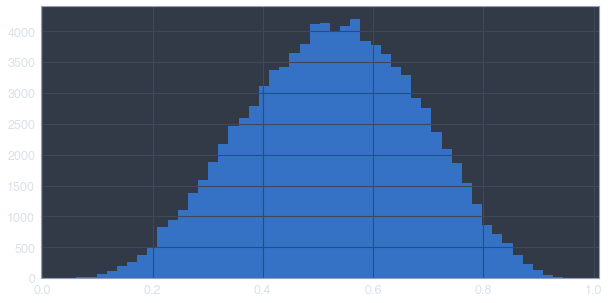

In [8]:
# Sanity check probability distribution
plt.figure(figsize=(10,5));
probs = [
    a for a, b in reg.predict_proba(predict_df)
]
plt.hist(probs, bins=50);

In [9]:
average_team = raw_tournament_df.mean().to_dict()
average_team

{'Season': 2011.095406360424,
 'TeamID': 1294.6272084805653,
 'SeedInt': 8.719081272084805,
 'OwnScore_Zscore': 0.3944827165002876,
 'OppScore_Zscore': -0.32319314544724476,
 'Offense': 0.07128957105304286,
 'Dominance': 0.7176758619475324,
 'Competition': 0.061760127355629496,
 'OffCompetition': 0.03097264409291073,
 'DefCompetition': -0.030787483262718757,
 'Wins': 0.946113074204947}

In [10]:
from functools import lru_cache

@lru_cache(maxsize=4096)
def calc_prob(predict_data):
    return reg.predict_proba(scaler.transform([predict_data]))[0][1]

def get_power_rating(team):
    return calc_prob((
            team["OwnScore_Zscore"], average_team["OwnScore_Zscore"],
            team["OppScore_Zscore"], average_team["OppScore_Zscore"],
            team["OffCompetition"], average_team["OffCompetition"],
            team["DefCompetition"], average_team["DefCompetition"],
        ))

In [11]:
def scatter_text(x, y, labelseries, labelsize='large', labelcolor='black', **kwargs):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x=x, y=y, **kwargs)
    # Add text besides each point
    offset = 0.01 * (max(x) - min(x))
    for line in range(len(x)):
         p1.text(
             x.iloc[line]+offset, y.iloc[line], 
             labelseries.iloc[line], size=labelsize, color=labelcolor
         )
    return p1

In [12]:
# Best teams of all time
raw_tournament_df["PowerRating"] = raw_tournament_df.apply(get_power_rating, axis=1)
raw_tournament_df["PowerOdds"] = raw_tournament_df["PowerRating"] / (1-raw_tournament_df["PowerRating"])
raw_tournament_df["PowerLogOdds"] = np.log(raw_tournament_df["PowerOdds"])

raw_tournament_df.sort_values(by="PowerRating", ascending=False)[[
    "Season", "TeamName", "Seed", "PowerRating"
]][:25]

,Season,TeamName,Seed,PowerRating
403,2015,Kentucky,Y01,0.956376
223,2019,Duke,W01,0.934345
208,2004,Duke,W01,0.932170
305,2019,Gonzaga,X01,0.931010
612,2005,North Carolina,Z01,0.928365
1030,2019,Virginia,Z01,0.923060
1021,2018,Villanova,W01,0.919527
371,2010,Kansas,Y01,0.919120
369,2008,Kansas,X01,0.918367
335,2013,Indiana,W01,0.917429


In [13]:
raw_tournament_df.groupby("Season").mean()[[
    "Dominance", "Competition", "PowerRating"
]]

,Dominance,Competition,PowerRating
Season,,,
2003,0.688160,0.059406,0.500068
2004,0.693042,0.058967,0.503301
2005,0.711328,0.056945,0.501434
2006,0.707615,0.052679,0.485527
2007,0.699795,0.056923,0.499204
2008,0.717957,0.054088,0.500510
2009,0.714716,0.063755,0.508801
2010,0.783524,0.061004,0.538831
2011,0.719389,0.065734,0.520858


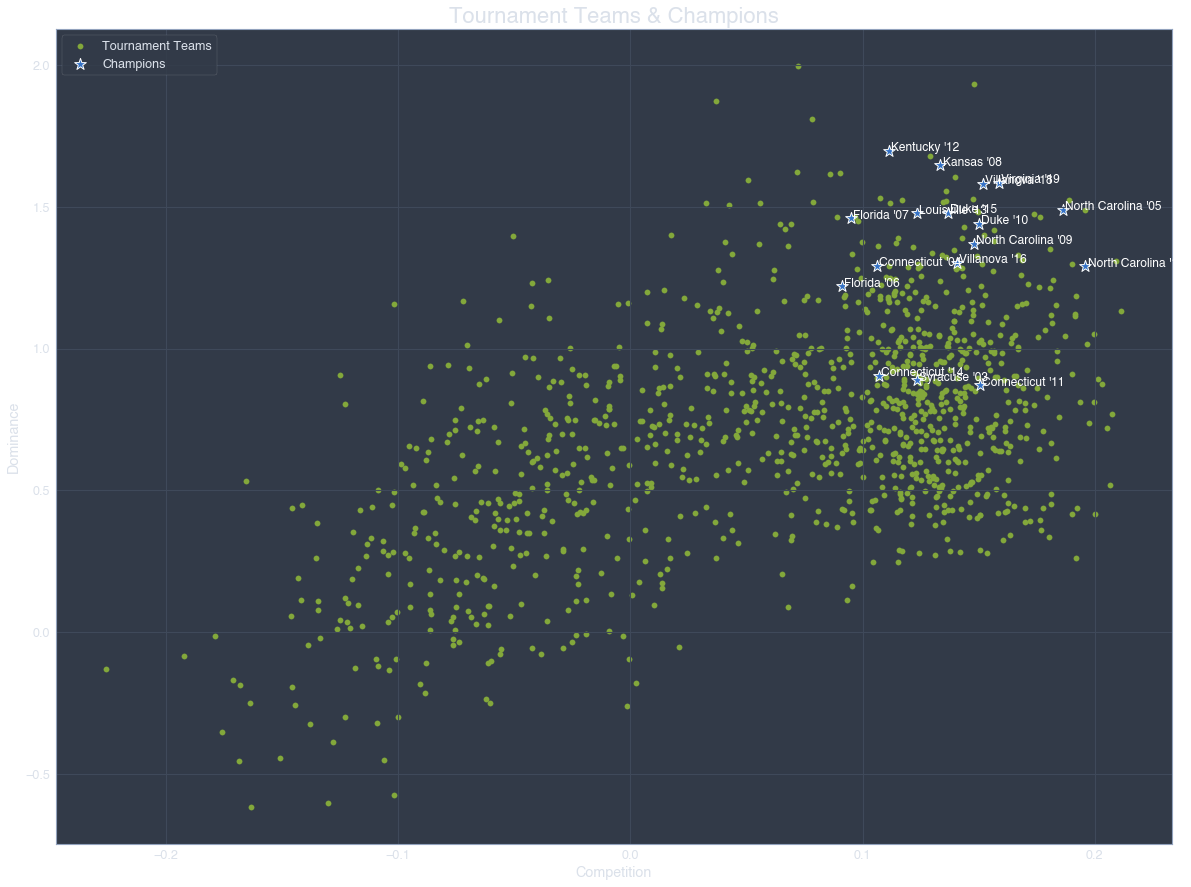

In [14]:
is_champion = raw_tournament_df["Wins"] >= 6
label_series = (
    raw_tournament_df[is_champion]["TeamName"] + " '" +
    raw_tournament_df[is_champion]["Season"].astype(str).str[-2:]
)

plt.figure(figsize=(20,15));
plt.title("Tournament Teams & Champions", fontsize=22)
plt.scatter(
    raw_tournament_df["Competition"],
    raw_tournament_df["Dominance"],
    color='g', label='Tournament Teams'
);
scatter_text(
    raw_tournament_df[is_champion]["Competition"], raw_tournament_df[is_champion]["Dominance"],
    color='b', marker='*', s=150, label='Champions',
    labelseries=label_series,
    labelcolor='white'
);
plt.legend(loc='upper left');

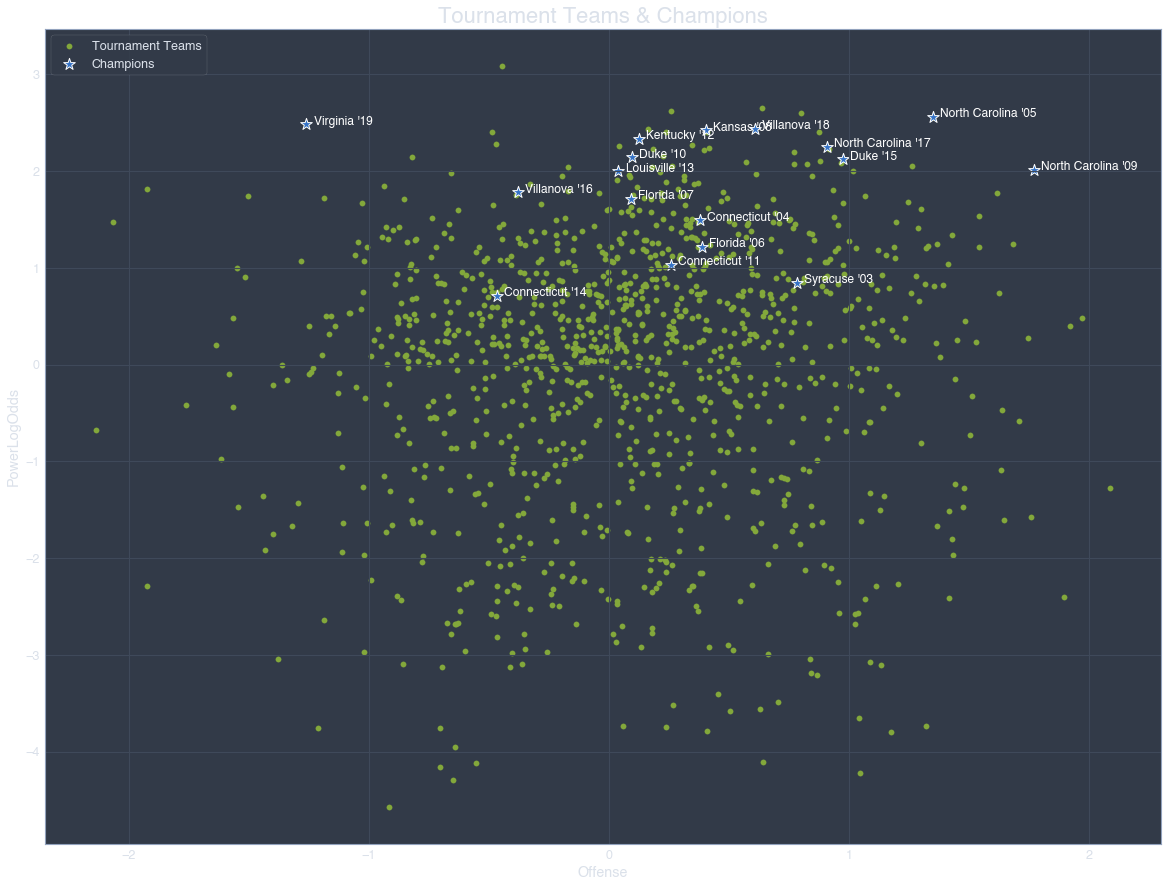

In [15]:
is_champion = raw_tournament_df["Wins"] >= 6
label_series = (
    raw_tournament_df[is_champion]["TeamName"] + " '" +
    raw_tournament_df[is_champion]["Season"].astype(str).str[-2:]
)

plt.figure(figsize=(20,15));
plt.title("Tournament Teams & Champions", fontsize=22)
plt.scatter(
    raw_tournament_df["Offense"],
    raw_tournament_df["PowerLogOdds"],
    color='g', label='Tournament Teams'
);
scatter_text(
    raw_tournament_df[is_champion]["Offense"], raw_tournament_df[is_champion]["PowerLogOdds"],
    color='b', marker='*', s=150, label='Champions',
    labelseries=label_series,
    labelcolor='white'
);
plt.legend(loc='upper left');

In [16]:
power_ratings = {}
slots_wins = defaultdict(lambda: defaultdict(int))
total_stats = defaultdict(lambda: defaultdict(int))
simulation_progression = []

SIMULATION_ROUNDS = 5000
SIM_MOD = SIMULATION_ROUNDS / 10
TOP_N = 5
for i in tqdm(range(SIMULATION_ROUNDS)):
    # INITIALIZE BRACKET (will be updated durign simulation)
    slots_dict = {
        row["Seed"]: row
        for _, row in tournament_df.iterrows()
    }
    
    for _, r in slots_df.iterrows():
        team_a = slots_dict[r["StrongSeed"]]
        team_b = slots_dict[r["WeakSeed"]]
        predict_data = (
            team_a["OwnScore_Zscore"], team_b["OwnScore_Zscore"],
            team_a["OppScore_Zscore"], team_b["OppScore_Zscore"],
            team_a["OffCompetition"], team_b["OffCompetition"],
            team_a["DefCompetition"], team_b["DefCompetition"],
        )
        prob = calc_prob(predict_data)
        winning_team = team_a if random.random() < prob else team_b
        slots_dict[r["Slot"]] = winning_team
        slots_wins[r["Slot"]][winning_team["TeamID"]] += 1
        total_stats[winning_team["TeamID"]]["wins"] += 1
        if r["Slot"][1] == "3":
            total_stats[winning_team["TeamID"]]["elite8"] += 1
        if r["Slot"][1] == "4":
            total_stats[winning_team["TeamID"]]["final4"] += 1
        
        # Get "difficulty" by looking at opposing power ratings
        power_a = get_power_rating(team_a)
        power_ratings[team_a["TeamID"]] = power_a
        total_stats[team_b["TeamID"]]["opp_power"] += power_a
        total_stats[team_b["TeamID"]]["opp_power_count"] += 1
        
        power_b = get_power_rating(team_b)
        power_ratings[team_b["TeamID"]] = power_b
        total_stats[team_a["TeamID"]]["opp_power"] += power_b
        total_stats[team_a["TeamID"]]["opp_power_count"] += 1
    
    # last winning team is champion
    total_stats[winning_team["TeamID"]]["championships"] +=1
    
    # Track top teams
    if (len(total_stats) > TOP_N) and ((i + 1) % SIM_MOD == 0):
        teams_by_championships = sorted(
            total_stats.items(), key=lambda x: x[1]["championships"], reverse=True
        )
        for team_id, stats in teams_by_championships[:TOP_N]:
            simulation_progression.append({
                "TeamID": team_id,
                "PercentChampion": stats["championships"] / (i + 1),
                "Rounds": i + 1
            })

100%|██████████| 5000/5000 [00:44<00:00, 112.26it/s]


In [17]:
power_df = pd.DataFrame([{"TeamID": k, "PowerRating": v} for k, v in power_ratings.items()])
tournament_df = tournament_df.merge(power_df, on="TeamID")

In [18]:
simulation_df = pd.DataFrame([
    {
        "TeamID": team_id,
        "AvgOppPower": results_dict["opp_power"] / results_dict["opp_power_count"],
        "MeanWins": results_dict["wins"] / SIMULATION_ROUNDS,
        "PercentElite8": results_dict["elite8"] / SIMULATION_ROUNDS,
        "PercentFinal4": results_dict["final4"] / SIMULATION_ROUNDS,
        "PercentChampion": results_dict["championships"] / SIMULATION_ROUNDS
    }
    for team_id, results_dict in total_stats.items()
])
simulation_df = simulation_df.merge(tournament_df, on="TeamID")[[
    "TeamID", "TeamName", "Seed",
    "OwnScore_Zscore",
    "OppScore_Zscore",
    "Offense",
    "Dominance",
    "Competition",
    "AvgOppPower",
    "PowerRating",
    "MeanWins",
    "PercentElite8",
    "PercentFinal4",
    "PercentChampion",
    "Wins"
]]

In [19]:
simulation_df["LogOdds"] = np.log(
    simulation_df["PercentChampion"] / (1-simulation_df["PercentChampion"])
).replace([np.inf, -np.inf], np.nan)
simulation_df["LogOdds"] = simulation_df["LogOdds"].fillna(simulation_df["LogOdds"].min())

/Users/jameswhedbee/miniforge3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


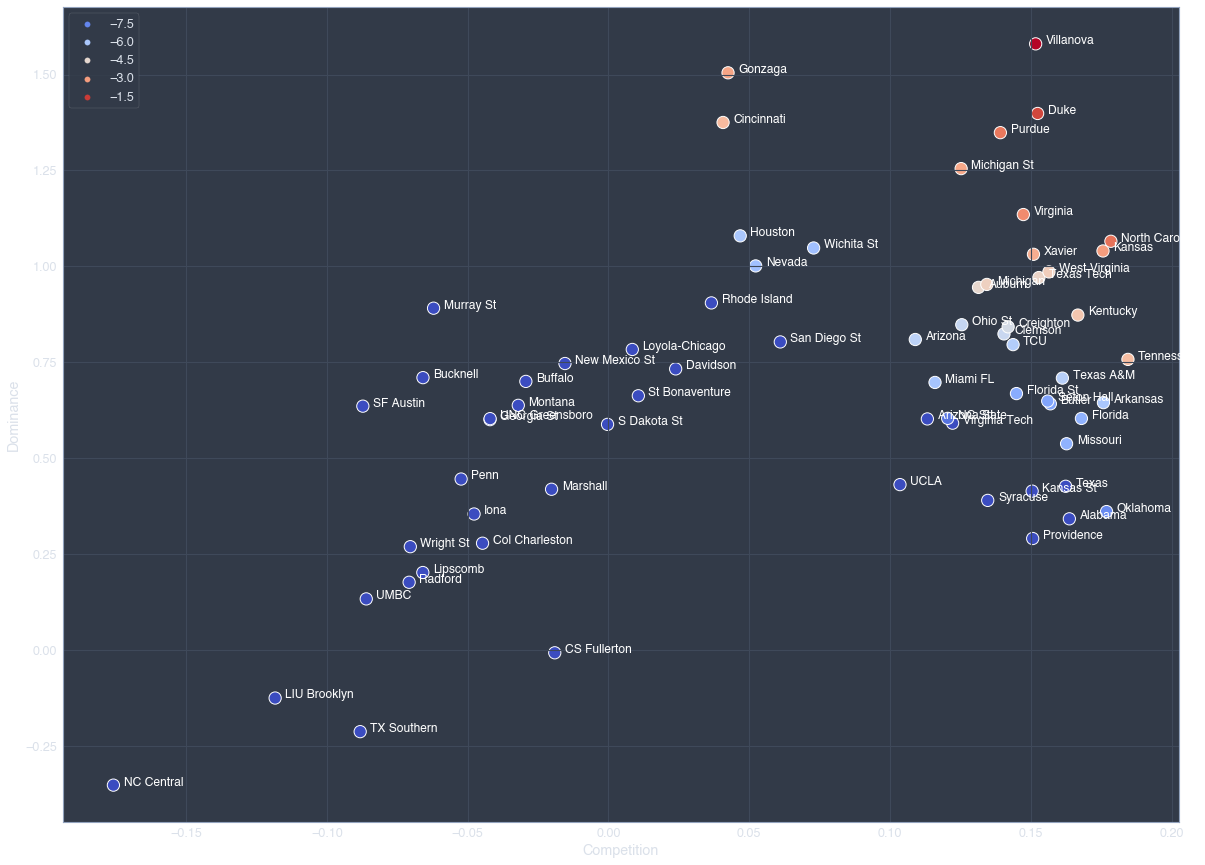

In [20]:
plt.figure(figsize=(20,15));
scatter_text(
    x=simulation_df["Competition"], y=simulation_df["Dominance"], s=150,
    hue=simulation_df["LogOdds"],
    palette=sns.color_palette("coolwarm", as_cmap=True),
    labelseries=simulation_df["TeamName"], labelcolor="white",
);
plt.legend(loc='upper left');

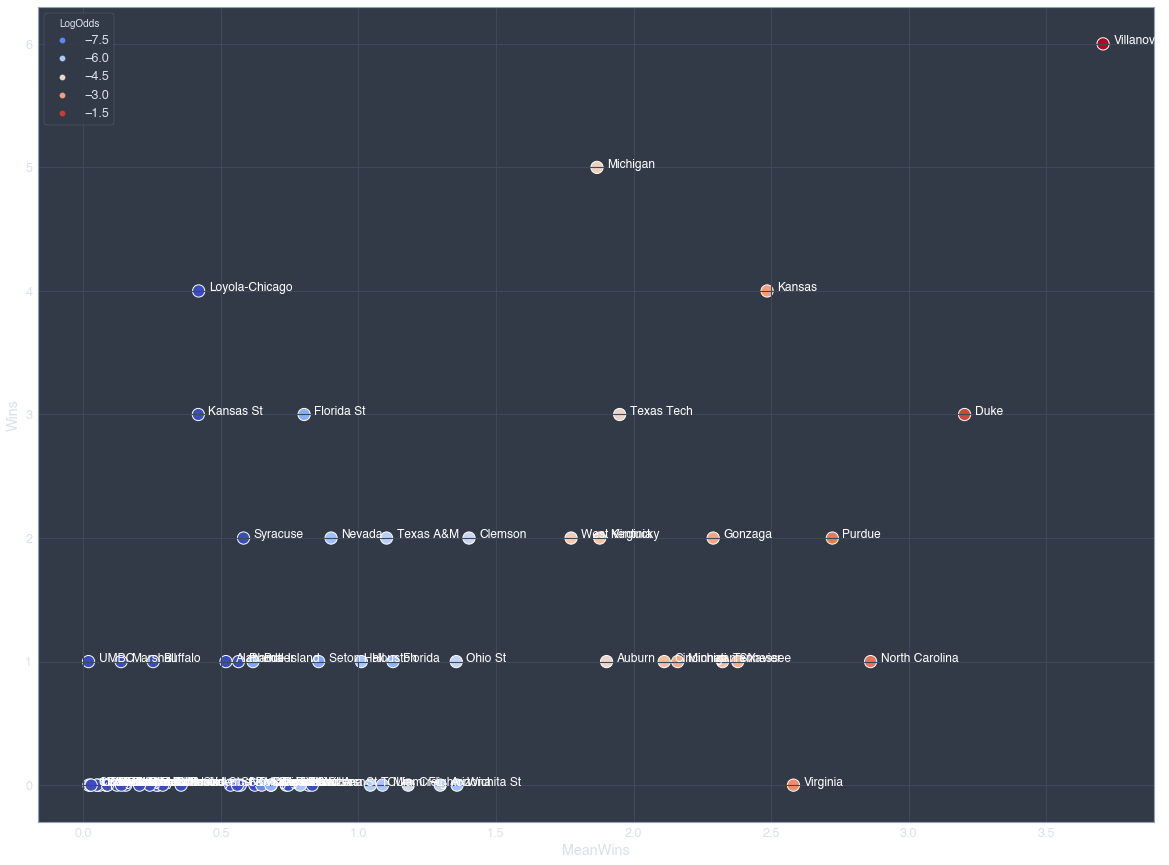

In [21]:
plt.figure(figsize=(20,15));
scatter_text(
    x=simulation_df["MeanWins"], y=simulation_df["Wins"], s=150,
    hue=simulation_df["LogOdds"], palette=sns.color_palette("coolwarm", as_cmap=True),
    labelseries=simulation_df["TeamName"], labelcolor="white"
);

In [22]:
BASIC_COLUMNS = ["TeamName", "Seed", "MeanWins", "PercentElite8", "PercentFinal4", "PercentChampion"]

In [23]:
# Who is the best team?
simulation_df.sort_values("PowerRating", ascending=False)[["PowerRating"] + BASIC_COLUMNS][:30]

,PowerRating,TeamName,Seed,MeanWins,PercentElite8,PercentFinal4,PercentChampion
8,0.919527,Villanova,W01,3.7070,0.7112,0.5072,0.2596
24,0.891147,Duke,X02,3.2034,0.5772,0.4142,0.1612
9,0.867845,Purdue,W02,2.7228,0.5280,0.2450,0.0866
54,0.841997,North Carolina,Z02,2.8618,0.5276,0.3244,0.0944
26,0.828325,Michigan St,X03,2.1606,0.2894,0.1682,0.0396
22,0.827682,Kansas,X01,2.4856,0.4664,0.2122,0.0482
37,0.814310,Virginia,Y01,2.5814,0.4310,0.2740,0.0642
58,0.798675,Gonzaga,Z04,2.2896,0.3690,0.1948,0.0418
53,0.794652,Xavier,Z01,2.3788,0.3760,0.1916,0.0348
15,0.786563,West Virginia,W05,1.7730,0.1754,0.0826,0.0158


In [24]:
# Who has the easiest schedule on average (excluding play ins)
is_not_play_in =  ~simulation_df["Seed"].str[-1].apply(str.isalpha)
simulation_df[is_not_play_in].sort_values(
    "AvgOppPower", ascending=True)[["AvgOppPower"] + BASIC_COLUMNS][:16]

,AvgOppPower,TeamName,Seed,MeanWins,PercentElite8,PercentFinal4,PercentChampion
41,0.486228,Tennessee,Y03,2.3238,0.3922,0.1950,0.0252
53,0.505259,Xavier,Z01,2.3788,0.3760,0.1916,0.0348
28,0.514264,Auburn,X04,1.9020,0.2598,0.0852,0.0112
37,0.520642,Virginia,Y01,2.5814,0.4310,0.2740,0.0642
39,0.529085,Cincinnati,Y02,2.1116,0.3354,0.1656,0.0264
11,0.536238,Texas Tech,W03,1.9496,0.2602,0.0832,0.0126
54,0.538805,North Carolina,Z02,2.8618,0.5276,0.3244,0.0944
43,0.540659,Arizona,Y04,1.2974,0.1158,0.0470,0.0036
13,0.540887,Wichita St,W04,1.3584,0.0784,0.0264,0.0020
56,0.545013,Michigan,Z03,1.8672,0.2316,0.1082,0.0146


In [25]:
# Who has the best chance to win
pie_df = simulation_df.sort_values("PercentChampion", ascending=False)
pie_df[[
    "TeamName", "Seed", "PowerRating", "AvgOppPower", "PercentElite8", "PercentFinal4", "PercentChampion"
]][:10]

,TeamName,Seed,PowerRating,AvgOppPower,PercentElite8,PercentFinal4,PercentChampion
8,Villanova,W01,0.919527,0.567191,0.7112,0.5072,0.2596
24,Duke,X02,0.891147,0.573557,0.5772,0.4142,0.1612
54,North Carolina,Z02,0.841997,0.538805,0.5276,0.3244,0.0944
9,Purdue,W02,0.867845,0.566887,0.5280,0.2450,0.0866
37,Virginia,Y01,0.814310,0.520642,0.4310,0.2740,0.0642
22,Kansas,X01,0.827682,0.556214,0.4664,0.2122,0.0482
58,Gonzaga,Z04,0.798675,0.559713,0.3690,0.1948,0.0418
26,Michigan St,X03,0.828325,0.583921,0.2894,0.1682,0.0396
53,Xavier,Z01,0.794652,0.505259,0.3760,0.1916,0.0348
39,Cincinnati,Y02,0.745462,0.529085,0.3354,0.1656,0.0264


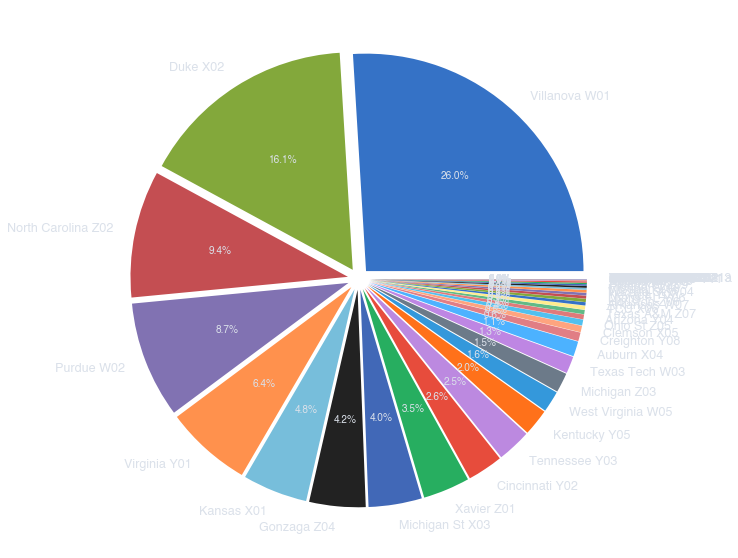

In [26]:
plt.figure(figsize=(10,10));
plt.pie(
    x=pie_df["PercentChampion"],
    labels=pie_df["TeamName"] + " " + pie_df["Seed"],
    autopct="%.1f%%",
    explode=[0.05]*len(simulation_df),
);

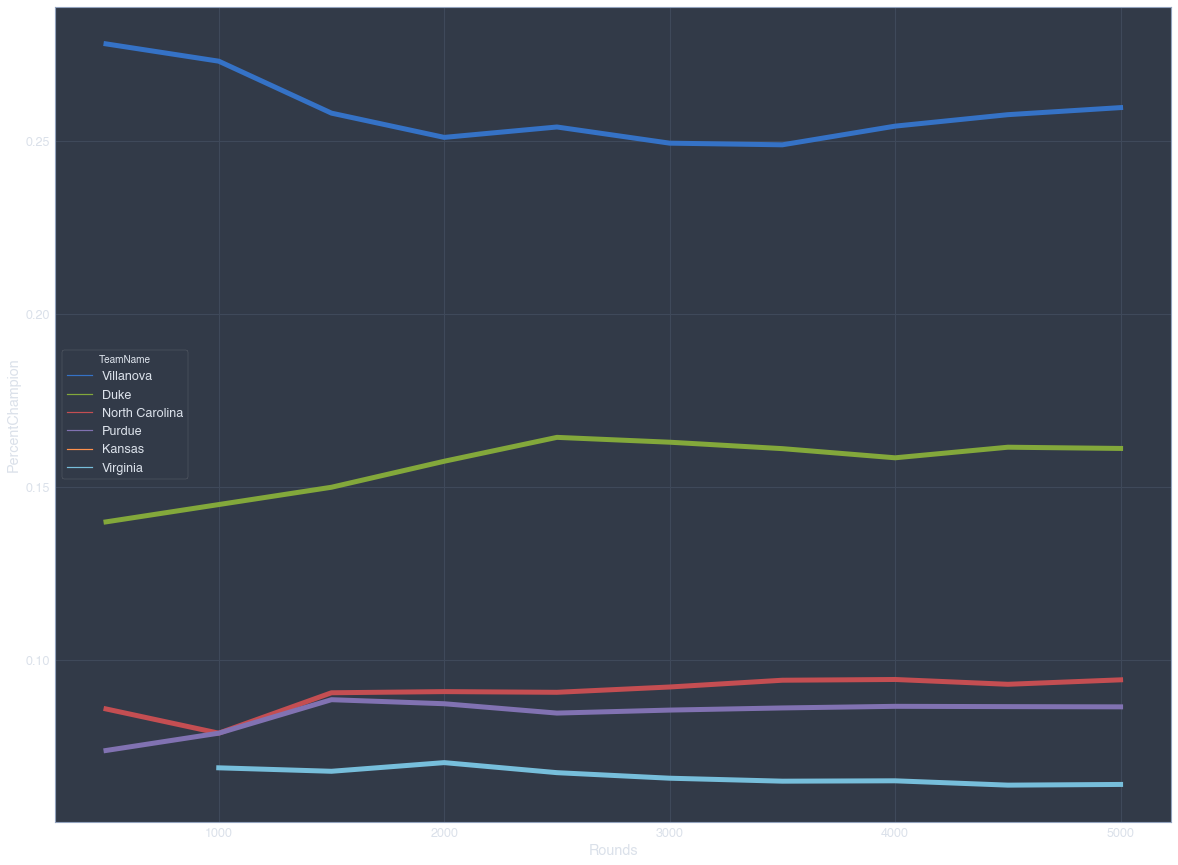

In [27]:
# Confirm % looks stable over time
plt.figure(figsize=(20,15));
progression_df = pd.DataFrame(simulation_progression).merge(
    tournament_df[["TeamID", "TeamName"]], on="TeamID"
)
sns.lineplot(
    data=progression_df,
    x="Rounds", y="PercentChampion", hue="TeamName", linewidth=5
);

In [28]:
 # What is the most common bracket?
bracket_slots = []
for slot, win_dict in slots_wins.items():
    top_teams = sorted(((v, k) for k, v in win_dict.items()), reverse=True)
    max_count, max_team_id = top_teams[0]
    runner_count, runner_team_id = top_teams[1]
    total = sum(v for v in win_dict.values())
    bracket_slots.append({
        "Slot": slot,
        "WinTeamID": max_team_id,
        "WinPct": max_count / total,
        "RunnerTeamID": runner_team_id,
        "RunnerWinPct": runner_count / total,
    })

bracket_df = pd.DataFrame(bracket_slots).merge(
    tournament_df[["TeamID", "TeamName", "Seed"]], left_on="WinTeamID", right_on="TeamID"
).rename(columns={"TeamName": "WinTeamName", "Seed": "WinSeed"}).merge(
    tournament_df[["TeamID", "TeamName", "Seed"]], left_on="RunnerTeamID", right_on="TeamID"
).rename(columns={"TeamName": "RunnerTeamName", "Seed": "RunnerSeed"})
bracket_df["Round"] = bracket_df["Slot"].apply(lambda x: int(x[1]) if x.startswith("R") else 0)
bracket_df = bracket_df[[
    "Slot", "Round",
    "WinTeamName", "WinSeed", "WinPct",
    "RunnerTeamName", "RunnerSeed", "RunnerWinPct"
]]

In [29]:
bracket_df[bracket_df["Round"] == 3].sort_values("WinPct", ascending=False)

,Slot,Round,WinTeamName,WinSeed,WinPct,RunnerTeamName,RunnerSeed,RunnerWinPct
6,R3W1,3,Villanova,W01,0.7112,West Virginia,W05,0.1754
26,R3X2,3,Duke,X02,0.5772,Michigan St,X03,0.2894
12,R3W2,3,Purdue,W02,0.5280,Texas Tech,W03,0.2602
57,R3Z2,3,North Carolina,Z02,0.5276,Michigan,Z03,0.2316
23,R3X1,3,Kansas,X01,0.4664,Auburn,X04,0.2598
38,R3Y1,3,Virginia,Y01,0.4310,Kentucky,Y05,0.2726
44,R3Y2,3,Tennessee,Y03,0.3922,Cincinnati,Y02,0.3354
53,R3Z1,3,Xavier,Z01,0.3760,Gonzaga,Z04,0.3690


In [30]:
# Submit to Kaggle
import itertools
predictions = []
for year in range(2015, 2020):
    submit_df = raw_tournament_df[raw_tournament_df["Season"] == year].set_index(["Season", "TeamID"])
    ids = sorted(submit_df.loc[year].index)
    for id_a, id_b in itertools.product(ids, ids):
        if id_a >= id_b:
            continue
        team_a = submit_df.loc[(year, id_a)]
        team_b = submit_df.loc[(year, id_b)]
        predict_data = (
            team_a["OwnScore_Zscore"], team_b["OwnScore_Zscore"],
            team_a["OppScore_Zscore"], team_b["OppScore_Zscore"],
            team_a["OffCompetition"], team_b["OffCompetition"],
            team_a["DefCompetition"], team_b["DefCompetition"],
        )
        prob = calc_prob(predict_data)
        predictions.append({
            "ID": f"{year}_{id_a}_{id_b}",
            "Pred": prob
        })

In [31]:
pred_df = pd.DataFrame(predictions)
pred_df.to_csv(f"{DATA_DIR}/output/kaggle_submission.csv", index=False)